In [0]:
import requests
import os, time

In [0]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import imageio

In [0]:
from google.colab.patches import cv2_imshow

In [0]:
from IPython.display import clear_output

In [5]:
%tensorflow_version 2.0.x
import tensorflow as tf

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0.x`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [0]:
import tensorflow.keras.utils as np_utils

In [0]:
access_token = '1094213176:AAFPM2lzoWH_fvQXgDjUtluJCctamMp5Ax0'

class botCallback(tf.keras.callbacks.Callback):
    def __init__(self,access_token):
        self.access_token = access_token
        self.ping_url = 'https://api.telegram.org/bot'+str(self.access_token)+'/getUpdates'
        self.response = requests.get(self.ping_url).json()
        self.chat_id = self.response['result'][0]['message']['chat']['id']

    def send_message(self,message):
        #print('sending message')
        self.ping_url = 'https://api.telegram.org/bot'+str(self.access_token)+'/sendMessage?'+\
                        'chat_id='+str(self.chat_id)+\
                        '&parse_mode=Markdown'+\
                        '&text='+message
        self.response = requests.get(self.ping_url)
    
    def send_photo(self,filepath):
        imagefile= open(filepath,"rb")
        file_dict = {'photo':imagefile}
        self.ping_url = 'https://api.telegram.org/bot'+str(self.access_token)+'/sendPhoto?chat_id='+str(self.chat_id)
        self.response = requests.post(self.ping_url, files = file_dict)
        imagefile.close()

    def on_epoch_end(self, epoch, logs=None):

        message = ' Epoch {}\n Training Accuracy : {:7.2f}\n Training Loss : {:7.2f}\n'.format(epoch,logs['accuracy'],logs['loss'])
        message += ' Validation Accuracy : {:7.2f}\n Validation Loss : {:7.2f}\n'.format(logs['val_accuracy'],logs['val_loss'])
        self.send_message(message)

In [0]:
class Plotter(botCallback):
    def __init__(self,acess_token):
        super().__init__(access_token)

    def on_train_begin(self,logs=None):
        self.batch = 0
        self.epoch = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.fig = plt.figure(figsize=(200,100))
        self.logs = []
    
    def on_epoch_end(self, epoch, logs=None):

        self.logs.append(logs)
        self.epoch.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['accuracy'])
        self.val_acc.append(logs['val_accuracy'])

        f,(ax1,ax2) = plt.subplots(1,2,sharex=True)

        clear_output(wait=True)

        ax1.plot(self.epoch, self.train_loss, label='Training Loss')
        ax1.plot(self.epoch, self.val_loss, label='Validation Loss')
        ax1.legend()

        ax2.plot(self.epoch, self.train_acc, label='Training Accuracy')
        ax2.plot(self.epoch, self.val_acc, label='Validation Accuracy')
        ax2.legend()

        plt.savefig('Accuracy and Loss plot.jpg')
        self.send_photo('/content/Accuracy and Loss plot.jpg')

In [0]:
bot = botCallback(access_token)
plotter = Plotter(access_token)

In [0]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [0]:
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# build the model
model = baseline_model()

In [0]:
#os.makedirs('/content/saved_models/')
save_dir = '/content/saved_models/'
model_name = 'keras_trained_model.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+model_name, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5)

#history = tf.keras.callbacks.LossHistory()

callbacks_list = [checkpoint, early, bot, plotter]

300/300 - 3s - loss: 0.0076 - accuracy: 0.9987 - val_loss: 0.0571 - val_accuracy: 0.9827


<Figure size 14400x7200 with 0 Axes>

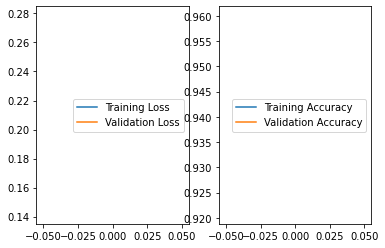

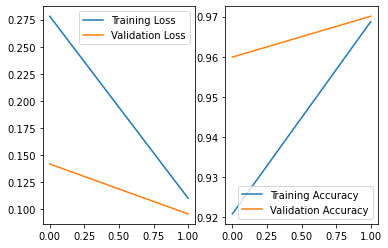

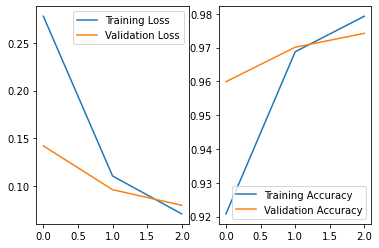

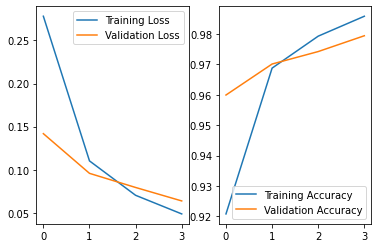

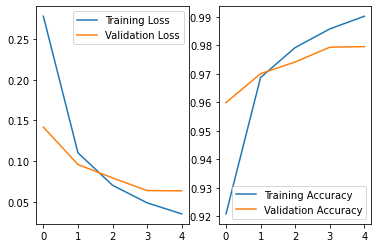

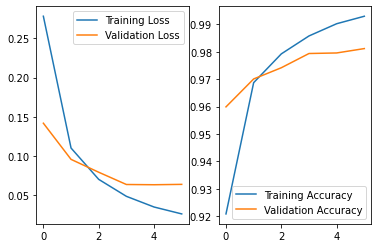

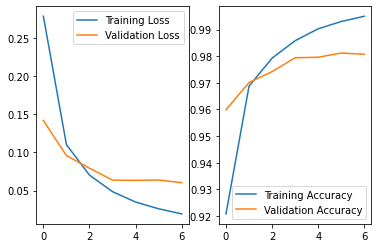

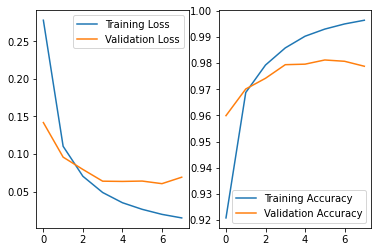

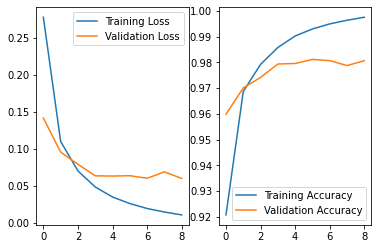

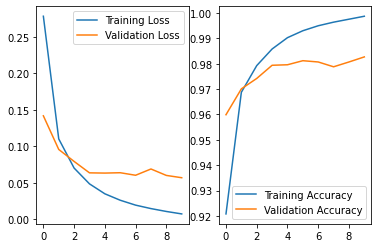

In [67]:
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, callbacks=callbacks_list, batch_size=200, verbose=2)

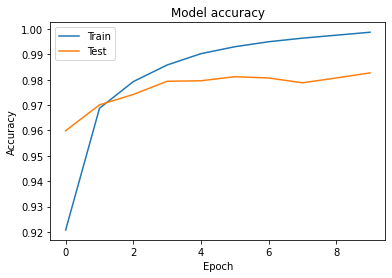

In [68]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('accuracy_plot.png')
plt.show()

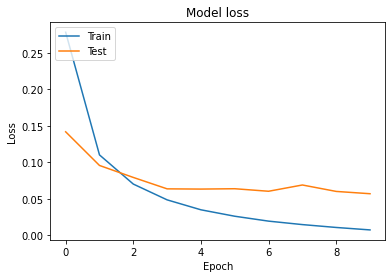

In [69]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('loss_plot.png')
plt.show()

In [70]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 1.73%


In [0]:
plotter.send_photo('/content/accuracy_plot.png')
plotter.send_photo('/content/loss_plot.png')